<a href="https://colab.research.google.com/github/OJB-Quantum/QC-Hardware-How-To/blob/main/Jupyter%20Notebook%20Scripts/Wigner_Functions_and_I_Q_Plots_on_2_Qubits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title System & Python dependencies (FFmpeg, QuTiP; optional CuPy GPU)
!apt-get -qq update
!apt-get -qq install -y ffmpeg

# Base scientific stack
!pip -q install "qutip>=5.0.0" qutip-qip imageio imageio-ffmpeg

# Try to install a CUDA 12.x CuPy on current Colab (T4 works with CUDA 12 runtime images).
# If it fails, we will just fall back to NumPy on CPU.
try:
    import cupy
    _cupy_already = True
except Exception:
    _cupy_already = False

if not _cupy_already:
    # Prefer CUDA 12 build; if your Colab image is older, switch to cupy-cuda11x.
    try:
        !pip -q install "cupy-cuda12x>=13.0.0"
    except Exception:
        !pip -q install "cupy-cuda11x>=13.0.0" || true

# Verify GPU presence
import subprocess, sys
gpustr = subprocess.run(["nvidia-smi"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
print(gpustr.stdout[:600] if gpustr.returncode==0 else "No NVIDIA GPU found.", file=sys.stderr)


In [5]:
#@title Imports, GPU/CPU selection, helpers, and plotting defaults
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation, writers
from IPython.display import HTML, display
import imageio, os
from math import pi

# QuTiP for states & gates
from qutip import basis, tensor, ket2dm, qeye, sigmaz, sigmax, sigmay

# GPU or CPU arrays
try:
    import cupy as cp
    _ = cp.cuda.runtime.getDeviceCount()
    GPU_ENABLED = True
except Exception:
    import numpy as cp  # type: ignore
    GPU_ENABLED = False

print(f"GPU acceleration via CuPy: {GPU_ENABLED}")

# Matplotlib defaults: safe for Colab
plt.rcParams["figure.dpi"] = 160
plt.rcParams["animation.embed_limit"] = 1000  # MB
plt.rcParams["savefig.bbox"] = "tight"

def safe_name(s: str) -> str:
    """Filesystem-safe name (avoid TeX tokens, slashes, etc.)."""
    return "".join(ch if ch.isalnum() or ch in "-_." else "_" for ch in s)

def spherical_grid(n_theta: int = 121, n_phi: int = 241):
    """(θ, φ) mesh over [0, π] × [0, 2π) using the active array backend (cp)."""
    theta = cp.linspace(0.0, cp.pi, n_theta)
    phi   = cp.linspace(0.0, 2.0*cp.pi, n_phi)
    TH, PH = cp.meshgrid(theta, phi, indexing="ij")
    return TH, PH

def bloch_vector(rho):
    """Return Bloch vector (rx, ry, rz) of a 2×2 QuTiP density matrix (NumPy floats)."""
    rx = float((rho * sigmax()).tr().real)
    ry = float((rho * sigmay()).tr().real)
    rz = float((rho * sigmaz()).tr().real)
    return rx, ry, rz

def qubit_wigner_from_bloch(rx, ry, rz, TH, PH):
    """
    Spin-1/2 Stratonovich–Weyl Wigner:
        W(θ,φ) = (1/4π) * [ 1 + sqrt(3) * (r · n) ],
    n = (sinθ cosφ, sinθ sinφ, cosθ).
    Uses cp for GPU, np for CPU, depending on imports above.
    """
    s = cp.sin(TH)
    c = cp.cos(TH)
    cf = cp.cos(PH)
    sf = cp.sin(PH)
    # r·n on the sphere
    dot = rx*(s*cf) + ry*(s*sf) + rz*c
    W = (1.0/(4.0*cp.pi)) * (1.0 + cp.sqrt(3.0)*dot)
    return W


GPU acceleration via CuPy: True


In [6]:
#@title Build the requested circuit and state sequence
from qutip.qip.operations import snot, cnot, ry

# Initial state |00⟩
psi0 = tensor(basis(2, 0), basis(2, 0))

# Gate sequence:
# 1) H on q0
U1 = tensor(snot(), qeye(2))
# 2) CNOT q0→q1
U2 = cnot()
# 3) R_y(pi/4) on q1
U3 = tensor(qeye(2), ry(np.pi / 4.0))
# 4) Z on q1
U4 = tensor(qeye(2), sigmaz())
# 5) CNOT q0→q1
U5 = cnot()
# 6) H on q0
U6 = tensor(snot(), qeye(2))

step_labels = [
    "Init: |00⟩ (passive T1 / active reset)",
    "H on q0",
    "CNOT q0→q1",
    "R_y(π/4) on q1",
    "Z on q1",
    "CNOT q0→q1",
    "H on q0",
    "Pre-measurement"
]

# States after each step
psi_list = [psi0]
for U in [U1, U2, U3, U4, U5, U6]:
    psi_list.append(U * psi_list[-1])

# Reduced single-qubit density matrices
rho0_list, rho1_list = [], []
for psi in psi_list:
    rho = ket2dm(psi)
    rho0_list.append(rho.ptrace(0))
    rho1_list.append(rho.ptrace(1))

# Bloch vectors for each reduced state
bloch0 = [bloch_vector(r) for r in rho0_list]
bloch1 = [bloch_vector(r) for r in rho1_list]


In [7]:
#@title Compute Wigner(θ,φ) surfaces on GPU if available
# Sphere grid (on cp: CuPy if GPU, NumPy if CPU)
TH, PH = spherical_grid(n_theta=121, n_phi=241)

W0_list = []
W1_list = []
for (rx0, ry0, rz0), (rx1, ry1, rz1) in zip(bloch0, bloch1):
    W0 = qubit_wigner_from_bloch(rx0, ry0, rz0, TH, PH)
    W1 = qubit_wigner_from_bloch(rx1, ry1, rz1, TH, PH)
    W0_list.append(W0)
    W1_list.append(W1)

# Compute global z-limits consistently (on cp), then bring to float
zmin = float(cp.min(cp.concatenate([cp.asarray([cp.min(W) for W in W0_list]),
                                    cp.asarray([cp.min(W) for W in W1_list])])))
zmax = float(cp.max(cp.concatenate([cp.asarray([cp.max(W) for W in W0_list]),
                                    cp.asarray([cp.max(W) for W in W1_list])])))
zpad = 0.05 * (zmax - zmin + 1e-12)
zlim = (zmin - zpad, zmax + zpad)
zlim


(-0.07203797469509514, 0.23119291778699047)

In [10]:
#@title Animate 3D color-graded surfaces across steps (GPU→CPU copy for plotting)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Copy arrays to NumPy for Matplotlib (CuPy → NumPy if GPU was used)
X = cp.asnumpy(TH)
Y = cp.asnumpy(PH)
W0_np = [cp.asnumpy(W) for W in W0_list]
W1_np = [cp.asnumpy(W) for W in W1_list]

fig = plt.figure(figsize=(10, 4.5))
ax0 = fig.add_subplot(1, 2, 1, projection="3d")
ax1 = fig.add_subplot(1, 2, 2, projection="3d")

# Initial draw; keep references to the Poly3DCollection artists
surf0 = ax0.plot_surface(X, Y, W0_np[0], cmap=cm.viridis, linewidth=0, antialiased=True)
surf1 = ax1.plot_surface(X, Y, W1_np[0], cmap=cm.viridis, linewidth=0, antialiased=True)
surfaces = [surf0, surf1]  # mutable container for handles

for ax, title in [(ax0, "Qubit 0"), (ax1, "Qubit 1")]:
    ax.set_xlabel("θ (rad)")
    ax.set_ylabel("φ (rad)")
    ax.set_zlabel("Wigner W(θ, φ)")
    ax.set_zlim(*zlim)
    ax.set_title(title)
    ax.view_init(elev=30, azim=35)

title_text = fig.suptitle(step_labels[0], fontsize=12)

def update(frame_idx, surfaces=surfaces):
    # Remove previous surfaces safely
    for k, ax in enumerate([ax0, ax1]):
        try:
            surfaces[k].remove()
        except Exception:
            pass

    # Re-plot for the current frame and store the new artist handles
    surfaces[0] = ax0.plot_surface(X, Y, W0_np[frame_idx], cmap=cm.viridis, linewidth=0, antialiased=True)
    surfaces[1] = ax1.plot_surface(X, Y, W1_np[frame_idx], cmap=cm.viridis, linewidth=0, antialiased=True)

    # Update the step label
    title_text.set_text(step_labels[frame_idx])

    # Return artists (blit=False; returning is still fine)
    return [surfaces[0], surfaces[1], title_text]

# Create the animation
anim = FuncAnimation(fig, update, frames=len(W0_np), interval=900, blit=False)

# Save files
basename = safe_name("wigner_evolution_2qubits_gpu_ok")
mp4_path = f"{basename}.mp4"
gif_path = f"{basename}.gif"

# MP4 via ffmpeg if writer is available (apt-get ffmpeg was done earlier)
if writers.is_available("ffmpeg"):
    try:
        anim.save(mp4_path, writer="ffmpeg", fps=1, dpi=160)
    except Exception as e:
        print(f"FFmpeg write failed: {e}\nFalling back to GIF only.")
else:
    print("FFmpeg writer not available; skipping MP4.")

# GIF via pillow
anim.save(gif_path, writer="pillow", fps=1)

plt.close(fig)

# Inline HTML animation and saved-file report
display(HTML(anim.to_jshtml()))
print("Saved files:")
if os.path.exists(mp4_path):
    print("  MP4:", mp4_path)
print("  GIF:", gif_path)


Saved files:
  MP4: wigner_evolution_2qubits_gpu_ok.mp4
  GIF: wigner_evolution_2qubits_gpu_ok.gif


Example Wigner plot:

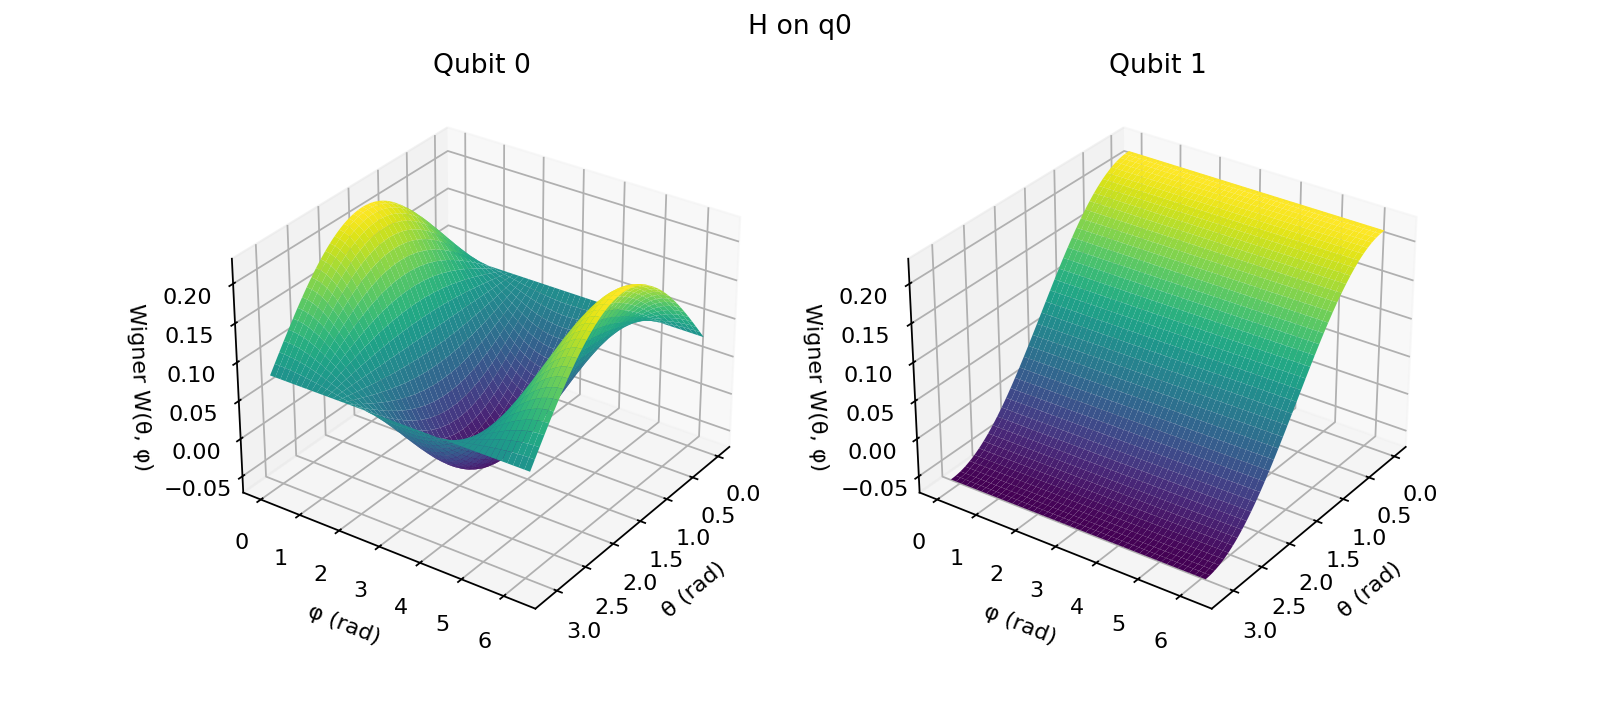

In [12]:
#@title Final state probabilities in computational basis (pre-measurement)
from qutip import basis, expect, tensor

# Computational-basis kets and labels
kets = [tensor(basis(2,i), basis(2,j)) for i in (0,1) for j in (0,1)]
labels = ["|00⟩", "|01⟩", "|10⟩", "|11⟩"]

psi_final = psi_list[-1]

# Use projectors |ij⟩⟨ij| and expectation values for probabilities
probs = [float(expect(ket * ket.dag(), psi_final)) for ket in kets]

print("Pre-measurement probabilities:")
for lab, p in zip(labels, probs):
    print(f"  P({lab}) = {p:.6f}")


Pre-measurement probabilities:
  P(|00⟩) = 0.000000
  P(|01⟩) = 0.146447
  P(|10⟩) = 0.853553
  P(|11⟩) = 0.000000


Saved: final_state_probabilities_single_shot_ideal.png
Saved: final_state_IQ_constellation_single_shot_ideal.png
Single-shot Ideal Qubit — Final-state amplitudes, phases, and probabilities (pre-measurement):


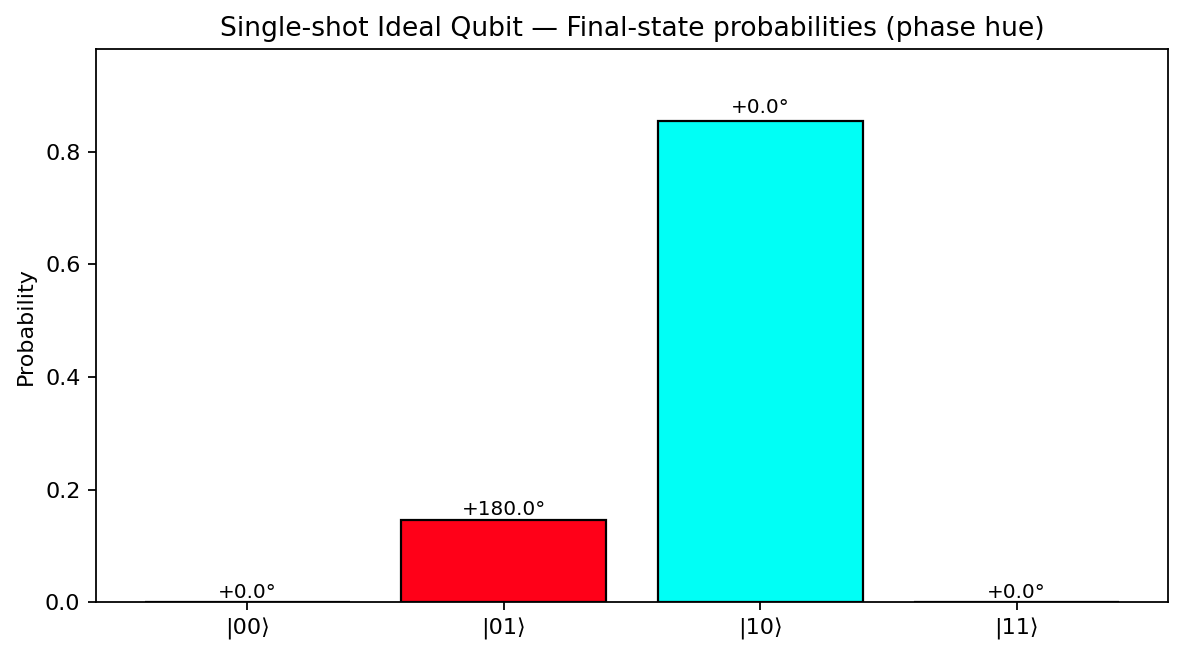

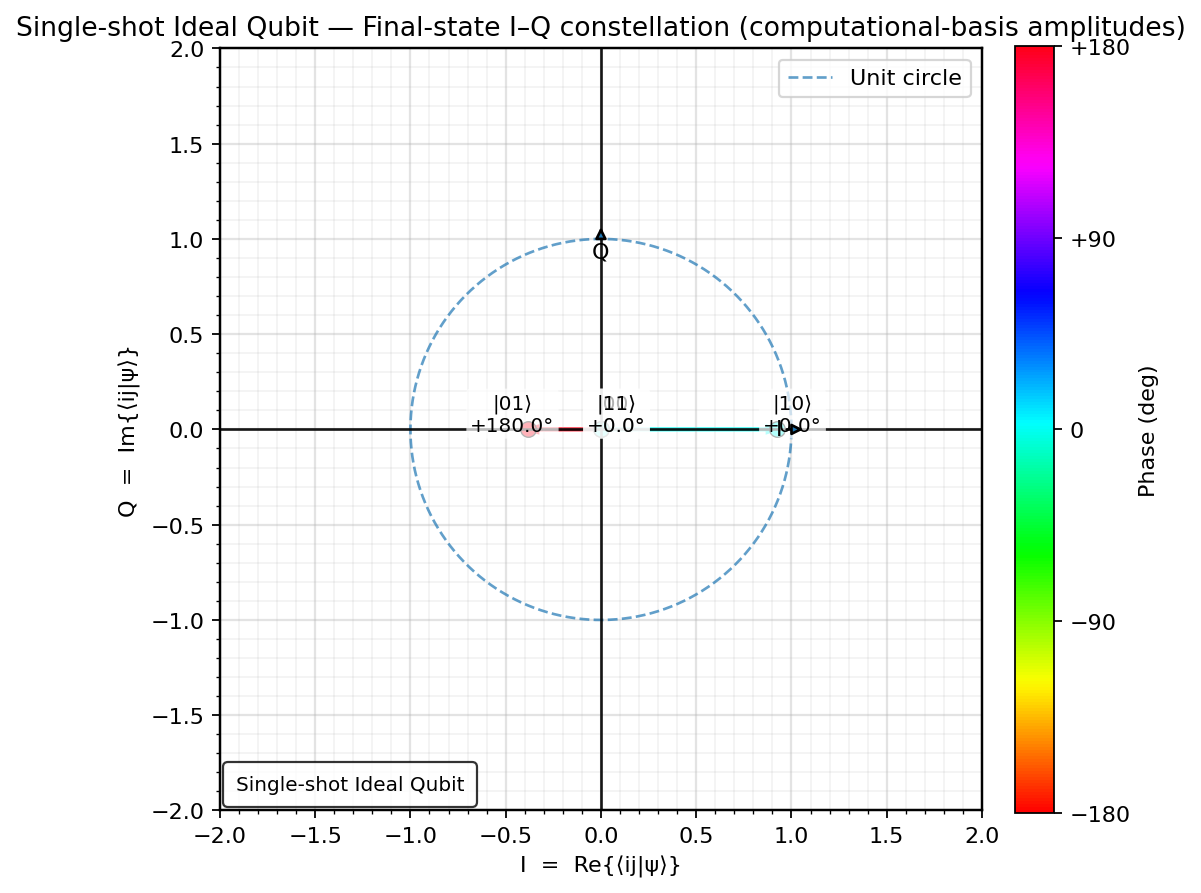

In [29]:
# --- PLOT 1: Probability bars, color-coded by phase ---
fig1, ax1 = plt.subplots(figsize=(7.5, 4.2))
x = np.arange(len(labels))
phase_norm = (ph_rad + np.pi) / (2*np.pi)
colors = plt.cm.hsv(phase_norm)

bars = ax1.bar(x, probs, color=colors, edgecolor="black")
ax1.set_xticks(x, labels)
ax1.set_ylabel("Probability")
ax1.set_title("Single-shot Ideal Qubit — Final-state probabilities (phase hue)")

for b, deg in zip(bars, ph_deg):
    ax1.text(b.get_x() + b.get_width()/2, b.get_height()*1.01, f"{deg:+.1f}°",
             ha="center", va="bottom", fontsize=9)

ax1.set_ylim(0, max(0.01, probs.max()*1.15))
fig1.tight_layout()
fig1.savefig("final_state_probabilities_single_shot_ideal.png", dpi=200)
print("Saved: final_state_probabilities_single_shot_ideal.png")

# --- PLOT 2: I–Q plane with improved formatting and label ---
import matplotlib as mpl
from matplotlib.offsetbox import AnchoredText

fig2, ax2 = plt.subplots(figsize=(6.8, 6.8))

theta = np.linspace(0, 2*np.pi, 512)
ax2.plot(np.cos(theta), np.sin(theta), linestyle="--", linewidth=1.2, alpha=0.7, label="Unit circle")

for lbl, I, Q, deg, c in zip(labels, I_part, Q_part, ph_deg, colors):
    ax2.arrow(0, 0, I, Q, head_width=0.03, head_length=0.05,
              length_includes_head=True, color=c, linewidth=1.6, alpha=0.9)
    ax2.plot(I, Q, "o", color=c, markersize=7, markeredgecolor="black", markeredgewidth=0.6)
    dx = 7 if I >= 0 else -7
    dy = 7 if Q >= 0 else -7
    ax2.annotate(f"{lbl}\n{deg:+.1f}°", xy=(I, Q), xytext=(dx, dy),
                 textcoords="offset points", ha="center", va="center",
                 fontsize=9, bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7))

r_pts = np.sqrt(I_part**2 + Q_part**2)
max_r = max(1.05, 1.15 * r_pts.max())
ax2.set_xlim(-max_r, max_r)
ax2.set_ylim(-max_r, max_r)

tick_step = 0.5 if max_r <= 2.0 else 1.0
ticks = np.arange(-np.ceil(max_r), np.ceil(max_r)+1e-9, tick_step)
ax2.set_xticks(ticks)
ax2.set_yticks(ticks)
ax2.minorticks_on()
ax2.grid(True, which="major", alpha=0.35, linewidth=1.0)
ax2.grid(True, which="minor", alpha=0.15, linewidth=0.8)
for spine in ax2.spines.values():
    spine.set_linewidth(1.1)

ax2.set_aspect("equal", adjustable="box")
ax2.set_xlabel("I  =  Re{⟨ij|ψ⟩}")
ax2.set_ylabel("Q  =  Im{⟨ij|ψ⟩}")
ax2.set_title("Single-shot Ideal Qubit — Final-state I–Q constellation (computational-basis amplitudes)")
ax2.legend(loc="upper right", frameon=True)

# I/Q axes with arrowheads
ax2.axhline(0, linewidth=1.2, alpha=0.9, color="black")
ax2.axvline(0, linewidth=1.2, alpha=0.9, color="black")
ax2.annotate("I", xy=(max_r, 0), xytext=(max_r*0.88, 0.0),
             arrowprops=dict(arrowstyle="-|>", lw=1.2, shrinkA=0, shrinkB=0),
             ha="center", va="center")
ax2.annotate("Q", xy=(0, max_r), xytext=(0.0, max_r*0.88),
             arrowprops=dict(arrowstyle="-|>", lw=1.2, shrinkA=0, shrinkB=0),
             ha="center", va="center")

# Small anchored tag in the corner
anch = AnchoredText("Single-shot Ideal Qubit", loc="lower left",
                    prop=dict(size=9), frameon=True, borderpad=0.4)
anch.patch.set_boxstyle("round,pad=0.25")
anch.patch.set_alpha(0.8)
ax2.add_artist(anch)

# Phase colorbar (matches HSV hue)
norm = mpl.colors.Normalize(vmin=-np.pi, vmax=np.pi)
sm = mpl.cm.ScalarMappable(cmap=plt.cm.hsv, norm=norm)
sm.set_array([])
cbar = fig2.colorbar(sm, ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label("Phase (deg)")
cbar.set_ticks(np.deg2rad([-180, -90, 0, 90, 180]))
cbar.set_ticklabels(["−180", "−90", "0", "+90", "+180"])

fig2.tight_layout()
fig2.savefig("final_state_IQ_constellation_single_shot_ideal.png", dpi=200)
print("Saved: final_state_IQ_constellation_single_shot_ideal.png")

print("Single-shot Ideal Qubit — Final-state amplitudes, phases, and probabilities (pre-measurement):")


Final-state, 4,000-shot outcome summary (pre-measurement):
Basis  Amplitude c = I + jQ  I = Re{c}  Q = Im{c}  Phase (rad)  Phase (deg)  Theoretical p  Shots (count)  Empirical p̂  Abs. error |p̂ - p|
 |00⟩    0.000000+0.000000j   0.000000        0.0     0.000000          0.0       0.000000              0         0.000             0.000000
 |01⟩   -0.382683+0.000000j  -0.382683        0.0     3.141593        180.0       0.146447            620         0.155             0.008553
 |10⟩    0.923880+0.000000j   0.923880        0.0     0.000000          0.0       0.853553           3380         0.845             0.008553
 |11⟩    0.000000+0.000000j   0.000000        0.0     0.000000          0.0       0.000000              0         0.000             0.000000
Saved: final_state_probabilities_4000shots.png
Saved: final_state_IQ_constellation_4000shots.png


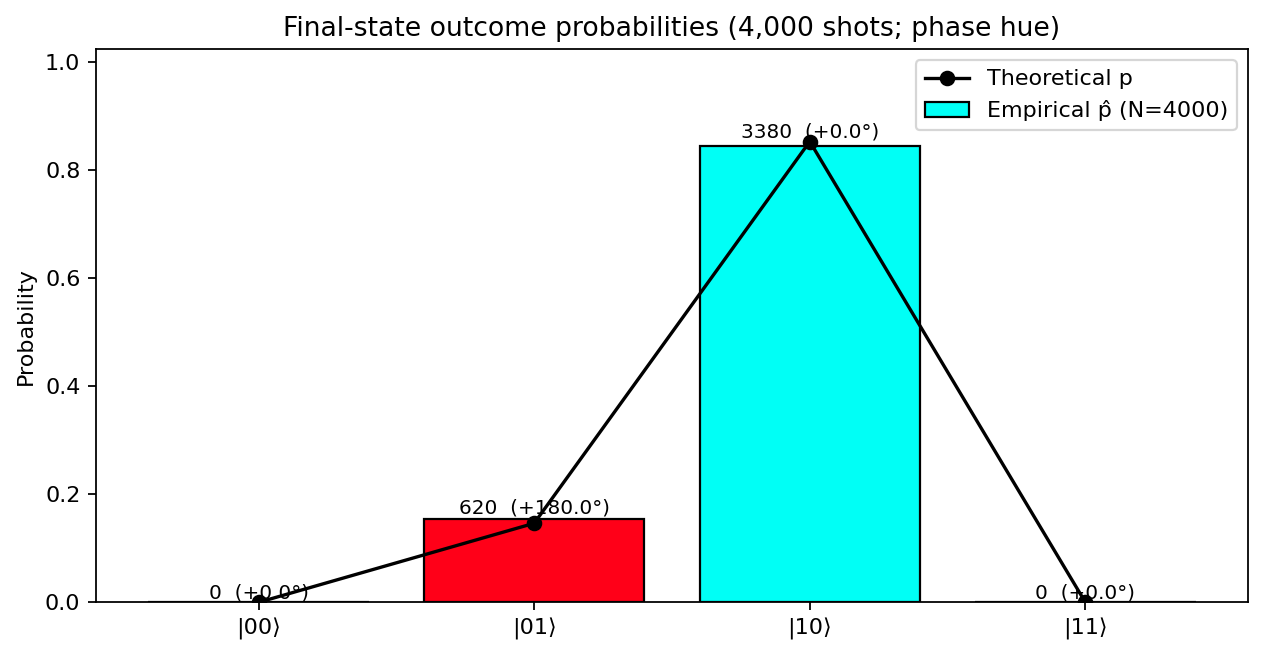

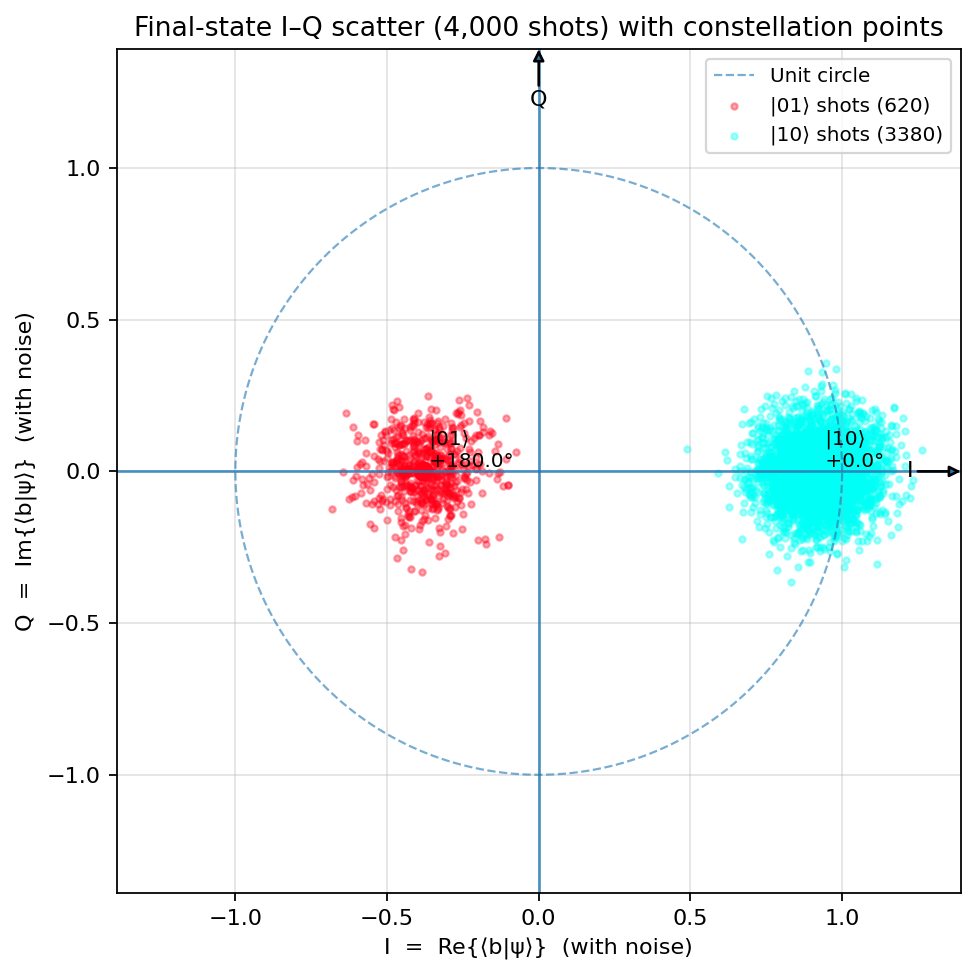

In [25]:
#@title 4,000-shot simulation, outcome table, probability bars, and I–Q plane
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qutip import basis, tensor

# -----------------------------
# 1) Exact amplitudes & probs
# -----------------------------
kets   = [tensor(basis(2,i), basis(2,j)) for i in (0,1) for j in (0,1)]
labels = ["|00⟩", "|01⟩", "|10⟩", "|11⟩"]
psi_final = psi_list[-1]

def amp_to_complex(a):
    try:
        return complex(a)  # scalar complex on newer QuTiP
    except Exception:
        return complex(a.full().ravel()[0])  # 1×1 Qobj

amps  = np.array([amp_to_complex(ket.dag() * psi_final) for ket in kets], dtype=complex)
probs = np.abs(amps)**2
ph_rad = np.angle(amps)
ph_deg = np.degrees(ph_rad)
I_part = amps.real
Q_part = amps.imag

# Check normalization (tolerant to rounding)
if not np.isclose(probs.sum(), 1.0, atol=1e-12):
    raise RuntimeError(f"Probabilities do not sum to 1. Sum={probs.sum()}")

# -----------------------------
# 2) Draw shots
# -----------------------------
rng = np.random.default_rng(20250925)  # deterministic for reproducibility
N_shots = 4000  # you can adjust this
outcome_idx = rng.choice(len(labels), size=N_shots, p=probs)

# Empirical counts and probabilities
counts = np.bincount(outcome_idx, minlength=len(labels))
empirical_probs = counts / N_shots

# -----------------------------
# 3) Assemble full results table
# -----------------------------
df = pd.DataFrame({
    "Basis": labels,
    "Amplitude c = I + jQ": amps,
    "I = Re{c}": I_part,
    "Q = Im{c}": Q_part,
    "Phase (rad)": ph_rad,
    "Phase (deg)": ph_deg,
    "Theoretical p": probs,
    "Shots (count)": counts,
    "Empirical p̂": empirical_probs,
    "Abs. error |p̂ - p|": np.abs(empirical_probs - probs)
})

print("Final-state, 4,000-shot outcome summary (pre-measurement):")
print(df.to_string(index=False))

# -----------------------------
# 4) Probability bar chart
# -----------------------------
fig1, ax1 = plt.subplots(figsize=(8.0, 4.2))
x = np.arange(len(labels))
phase_norm = (ph_rad + np.pi) / (2*np.pi)  # map [-pi,pi]->[0,1]
colors = plt.cm.hsv(phase_norm)

bars = ax1.bar(x, empirical_probs, color=colors, edgecolor="black", label="Empirical p̂ (N=4000)")
ax1.plot(x, probs, "o-", lw=1.5, label="Theoretical p", color="black")

ax1.set_xticks(x, labels)
ax1.set_ylabel("Probability")
ax1.set_title("Final-state outcome probabilities (4,000 shots; phase hue)")
ax1.set_ylim(0, max(0.01, max(empirical_probs.max(), probs.max())*1.2))
ax1.legend(loc="best", frameon=True)

# annotate with counts and phase
for i, (b, cnt, deg) in enumerate(zip(bars, counts, ph_deg)):
    ax1.text(b.get_x() + b.get_width()/2, b.get_height()*1.01,
             f"{cnt}  ({deg:+.1f}°)", ha="center", va="bottom", fontsize=9)

fig1.tight_layout()
fig1.savefig("final_state_probabilities_4000shots.png", dpi=200)
print("Saved: final_state_probabilities_4000shots.png")

# -----------------------------
# 5) I–Q plane scatter (noisy)
# -----------------------------
# Noise level approximates demodulated readout spread; adjust as desired.
noise_sigma = 0.10  # standard deviation per quadrature
# Generate one complex sample per shot, clustered around the state's amplitude
Z = np.empty(N_shots, dtype=complex)
for k in range(len(labels)):
    idx = np.where(outcome_idx == k)[0]
    if idx.size == 0:
        continue
    # circular complex Gaussian noise: n = nI + j nQ
    nI = rng.normal(0.0, noise_sigma, size=idx.size)
    nQ = rng.normal(0.0, noise_sigma, size=idx.size)
    Z[idx] = amps[k] + (nI + 1j*nQ)

# Plot
fig2, ax2 = plt.subplots(figsize=(6.2, 6.2))

# dashed unit circle
theta = np.linspace(0, 2*np.pi, 512)
ax2.plot(np.cos(theta), np.sin(theta), linestyle="--", lw=1.0, alpha=0.6, label="Unit circle")

# per-cluster scatters with consistent hue
for k, (lbl, c, color) in enumerate(zip(labels, amps, colors)):
    idx = np.where(outcome_idx == k)[0]
    if idx.size == 0:
        continue
    ax2.scatter(Z[idx].real, Z[idx].imag, s=8, alpha=0.35, color=color, label=f"{lbl} shots ({idx.size})")
    # mark the ideal constellation point and its phase
    ax2.plot(c.real, c.imag, "o", color=color, markersize=8)
    ax2.text(c.real, c.imag, f" {lbl}\n {np.degrees(np.angle(c)):+.1f}°", ha="left", va="bottom", fontsize=9)

# axes & aesthetics
max_r = max(1.2, 1.1*np.max(np.abs(np.concatenate([Z.real, Z.imag]))))
ax2.set_xlim(-max_r, max_r)
ax2.set_ylim(-max_r, max_r)
ax2.set_xlabel("I  =  Re{⟨b|ψ⟩}  (with noise)")
ax2.set_ylabel("Q  =  Im{⟨b|ψ⟩}  (with noise)")
ax2.set_title("Final-state I–Q scatter (4,000 shots) with constellation points")
ax2.grid(True, alpha=0.35)
ax2.set_aspect("equal", adjustable="box")
ax2.legend(loc="upper right", fontsize=9, frameon=True)

# --- Draw I and Q axes with arrowheads ---
# Full axes lines through the origin
ax2.axhline(0, linewidth=1.2, alpha=0.8)
ax2.axvline(0, linewidth=1.2, alpha=0.8)

# Arrowheads pointing to +I and +Q directions
ax2.annotate(
    "I", xy=(max_r, 0), xytext=(max_r*0.88, 0.0),
    arrowprops=dict(arrowstyle="-|>", lw=1.2, shrinkA=0, shrinkB=0),
    ha="center", va="center"
)
ax2.annotate(
    "Q", xy=(0, max_r), xytext=(0.0, max_r*0.88),
    arrowprops=dict(arrowstyle="-|>", lw=1.2, shrinkA=0, shrinkB=0),
    ha="center", va="center"
)

fig2.tight_layout()
fig2.savefig("final_state_IQ_constellation_4000shots.png", dpi=200)
print("Saved: final_state_IQ_constellation_4000shots.png")


Final-state, 50-shot FAULT-TOLERANT outcome summary (pre-measurement, with readout model):
Basis  Amplitude c = I + jQ  I = Re{c}  Q = Im{c}  Phase (deg)  Theoretical p  Shots (count)  Empirical p̂ (50)  Abs. error |p̂ - p|
 |00⟩    0.000000+0.000000j   0.000000        0.0          0.0       0.000000              0               0.00             0.000000
 |01⟩   -0.382683+0.000000j  -0.382683        0.0        180.0       0.146447              9               0.18             0.033553
 |10⟩    0.923880+0.000000j   0.923880        0.0          0.0       0.853553             41               0.82             0.033553
 |11⟩    0.000000+0.000000j   0.000000        0.0          0.0       0.000000              0               0.00             0.000000
Saved: final_state_probabilities_50shots_FT.png
Saved: final_state_IQ_constellation_50shots_FT.png


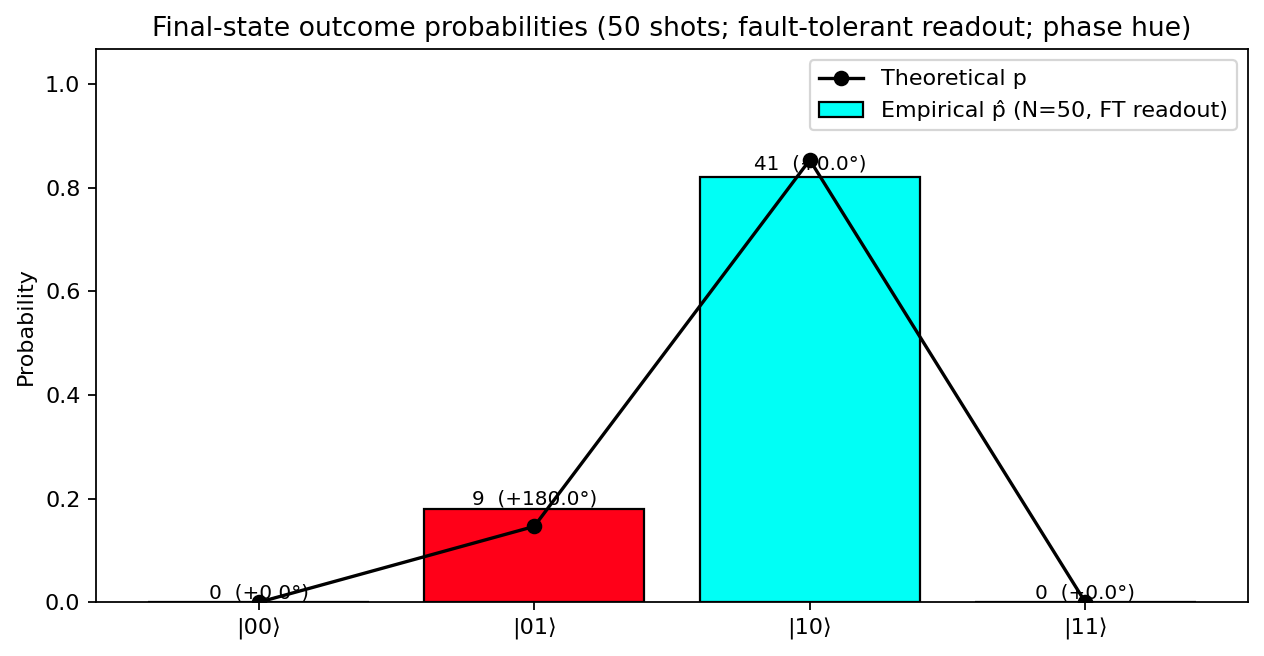

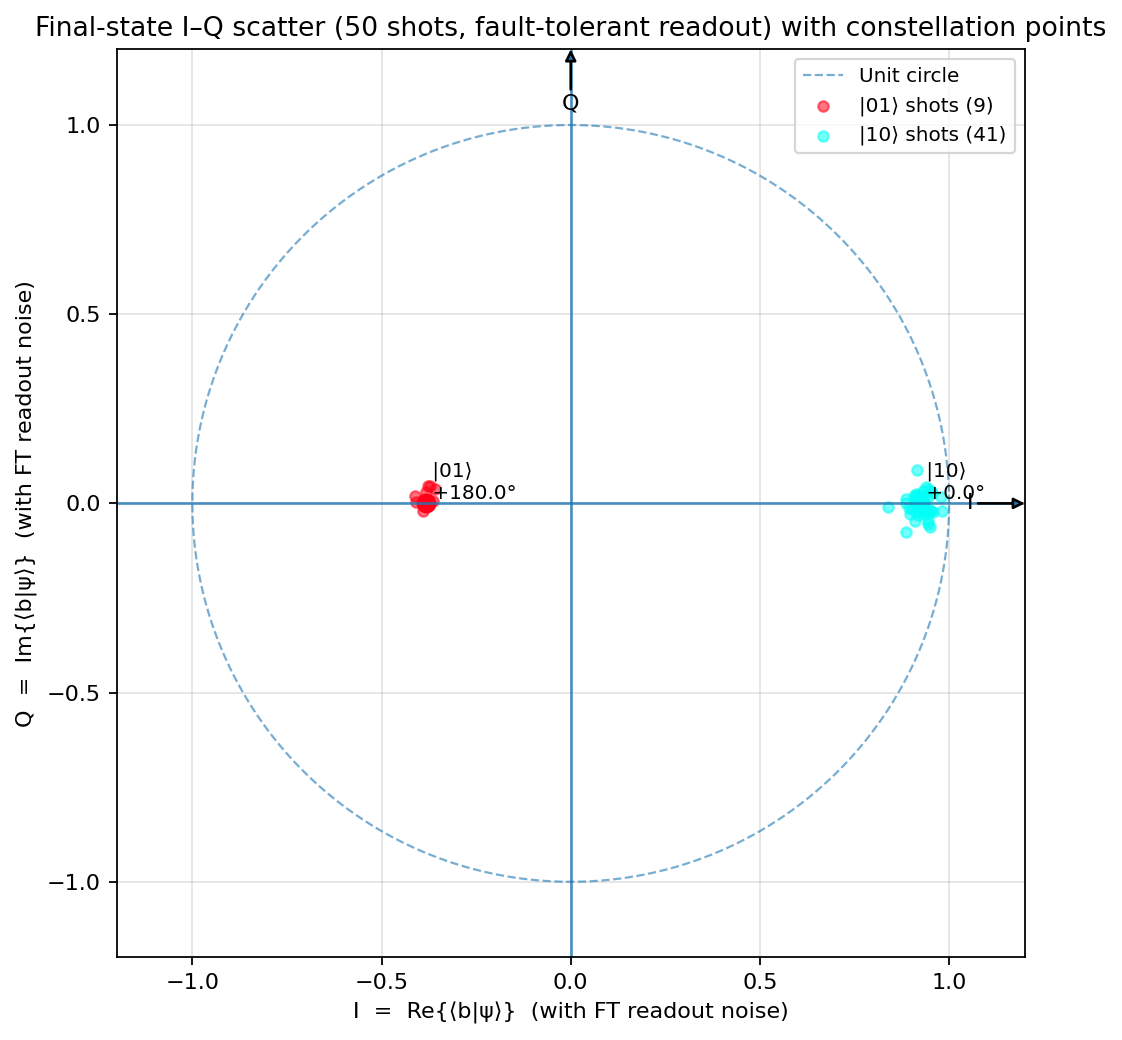

In [26]:
#@title 50-shot fault-tolerant simulation: outcomes, bars, and I–Q plane
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qutip import basis, tensor

# -----------------------------
# 1) Exact amplitudes & probs
# -----------------------------
kets   = [tensor(basis(2,i), basis(2,j)) for i in (0,1) for j in (0,1)]
labels = ["|00⟩", "|01⟩", "|10⟩", "|11⟩"]
psi_final = psi_list[-1]

def amp_to_complex(a):
    try:
        return complex(a)  # newer QuTiP returns scalar complex
    except Exception:
        return complex(a.full().ravel()[0])  # 1×1 Qobj

amps  = np.array([amp_to_complex(ket.dag() * psi_final) for ket in kets], dtype=complex)
probs = np.abs(amps)**2
ph_rad = np.angle(amps)
ph_deg = np.degrees(ph_rad)

# Sanity check
if not np.isclose(probs.sum(), 1.0, atol=1e-12):
    raise RuntimeError(f"Probabilities do not sum to 1. Sum={probs.sum()}")

# -----------------------------
# 2) Draw ideal shots, then apply fault-tolerant readout model
# -----------------------------
rng = np.random.default_rng(20250925)  # deterministic
N_SHOTS = 50

# Ideal outcomes from the final state distribution
ideal_idx = rng.choice(len(labels), size=N_SHOTS, p=probs)  # indices 0..3

# Fault-tolerant readout: independent per-qubit readout bit-flip with small p_ro
p_ro = 0.002  # 0.2% per qubit
# Map index -> 2-bit tuple (b0,b1)
idx_to_bits = np.array([[0,0],[0,1],[1,0],[1,1]])
bits = idx_to_bits[ideal_idx].copy()

# Apply independent flips
flip0 = rng.random(N_SHOTS) < p_ro
flip1 = rng.random(N_SHOTS) < p_ro
bits[:,0] ^= flip0.astype(int)
bits[:,1] ^= flip1.astype(int)

# Map bits back to indices
bits_to_idx = { (0,0):0, (0,1):1, (1,0):2, (1,1):3 }
observed_idx = np.array([bits_to_idx[(b0,b1)] for b0,b1 in bits], dtype=int)

# Empirical counts and probabilities after readout
counts = np.bincount(observed_idx, minlength=len(labels))
empirical_probs = counts / N_SHOTS

# -----------------------------
# 3) Full results table (theory vs empirical, FT readout)
# -----------------------------
I_part = amps.real
Q_part = amps.imag
df = pd.DataFrame({
    "Basis": labels,
    "Amplitude c = I + jQ": amps,
    "I = Re{c}": I_part,
    "Q = Im{c}": Q_part,
    "Phase (deg)": ph_deg,
    "Theoretical p": probs,
    "Shots (count)": counts,
    "Empirical p̂ (50)": empirical_probs,
    "Abs. error |p̂ - p|": np.abs(empirical_probs - probs)
})

print("Final-state, 50-shot FAULT-TOLERANT outcome summary (pre-measurement, with readout model):")
print(df.to_string(index=False))

# -----------------------------
# 4) Probability bar chart
# -----------------------------
fig1, ax1 = plt.subplots(figsize=(8.0, 4.2))
x = np.arange(len(labels))
phase_norm = (ph_rad + np.pi) / (2*np.pi)  # map [-pi,pi]→[0,1]
colors = plt.cm.hsv(phase_norm)

bars = ax1.bar(x, empirical_probs, color=colors, edgecolor="black",
               label=f"Empirical p̂ (N={N_SHOTS}, FT readout)")
ax1.plot(x, probs, "o-", lw=1.5, label="Theoretical p", color="black")

ax1.set_xticks(x, labels)
ax1.set_ylabel("Probability")
ax1.set_title(f"Final-state outcome probabilities ({N_SHOTS} shots; fault-tolerant readout; phase hue)")
ax1.set_ylim(0, max(0.01, max(empirical_probs.max(), probs.max())*1.25))
ax1.legend(loc="best", frameon=True)

# annotate with counts and phase
for b, cnt, deg in zip(bars, counts, ph_deg):
    ax1.text(b.get_x() + b.get_width()/2, b.get_height()*1.01,
             f"{cnt}  ({deg:+.1f}°)", ha="center", va="bottom", fontsize=9)

fig1.tight_layout()
fig1.savefig("final_state_probabilities_50shots_FT.png", dpi=200)
print("Saved: final_state_probabilities_50shots_FT.png")

# -----------------------------
# 5) I–Q plane scatter (tighter clusters, FT)
# -----------------------------
# Tighter demod noise to reflect high-fidelity readout
noise_sigma = 0.03  # per quadrature
Z = np.empty(N_SHOTS, dtype=complex)
for k in range(len(labels)):
    idx = np.where(observed_idx == k)[0]
    if idx.size == 0:
        continue
    nI = rng.normal(0.0, noise_sigma, size=idx.size)
    nQ = rng.normal(0.0, noise_sigma, size=idx.size)
    Z[idx] = amps[k] + (nI + 1j*nQ)

fig2, ax2 = plt.subplots(figsize=(6.6, 6.6))

# dashed unit circle
theta = np.linspace(0, 2*np.pi, 512)
ax2.plot(np.cos(theta), np.sin(theta), linestyle="--", lw=1.0, alpha=0.6, label="Unit circle")

# per-cluster scatter with consistent hue
for k, (lbl, c, color) in enumerate(zip(labels, amps, colors)):
    idx = np.where(observed_idx == k)[0]
    if idx.size == 0:
        continue
    ax2.scatter(Z[idx].real, Z[idx].imag, s=22, alpha=0.55, color=color,
                label=f"{lbl} shots ({idx.size})")
    ax2.plot(c.real, c.imag, "o", color=color, markersize=8)
    ax2.text(c.real, c.imag, f" {lbl}\n {np.degrees(np.angle(c)):+.1f}°",
             ha="left", va="bottom", fontsize=9)

# axes & aesthetics
max_r_data = 1.1*np.max([1.0,
                         np.abs(Z.real).max() if N_SHOTS>0 else 1.0,
                         np.abs(Z.imag).max() if N_SHOTS>0 else 1.0,
                         np.abs(I_part).max() if I_part.size else 1.0,
                         np.abs(Q_part).max() if Q_part.size else 1.0])
max_r = max(1.2, max_r_data)
ax2.set_xlim(-max_r, max_r)
ax2.set_ylim(-max_r, max_r)
ax2.set_xlabel("I  =  Re{⟨b|ψ⟩}  (with FT readout noise)")
ax2.set_ylabel("Q  =  Im{⟨b|ψ⟩}  (with FT readout noise)")
ax2.set_title(f"Final-state I–Q scatter ({N_SHOTS} shots, fault-tolerant readout) with constellation points")
ax2.grid(True, alpha=0.35)
ax2.set_aspect("equal", adjustable="box")
ax2.legend(loc="upper right", fontsize=9, frameon=True)

# --- Draw I and Q axes with arrowheads ---
ax2.axhline(0, linewidth=1.2, alpha=0.8)
ax2.axvline(0, linewidth=1.2, alpha=0.8)
ax2.annotate(
    "I", xy=(max_r, 0), xytext=(max_r*0.88, 0.0),
    arrowprops=dict(arrowstyle="-|>", lw=1.2, shrinkA=0, shrinkB=0),
    ha="center", va="center"
)
ax2.annotate(
    "Q", xy=(0, max_r), xytext=(0.0, max_r*0.88),
    arrowprops=dict(arrowstyle="-|>", lw=1.2, shrinkA=0, shrinkB=0),
    ha="center", va="center"
)

fig2.tight_layout()
fig2.savefig("final_state_IQ_constellation_50shots_FT.png", dpi=200)
print("Saved: final_state_IQ_constellation_50shots_FT.png")

Final-state, 20-shot TOPOLOGICALLY PROTECTED outcome summary (with ultra-low readout error):
Basis  Amplitude c = I + jQ  I = Re{c}  Q = Im{c}  Phase (deg)  Theoretical p  Shots (count)  Empirical p̂ (20)  Wilson 95% low  Wilson 95% high  Abs. error |p̂ - p|
 |00⟩    0.000000+0.000000j   0.000000        0.0          0.0       0.000000              0                0.0        0.000000         0.161130             0.000000
 |01⟩   -0.382683+0.000000j  -0.382683        0.0        180.0       0.146447              2                0.1        0.027866         0.301038             0.046447
 |10⟩    0.923880+0.000000j   0.923880        0.0          0.0       0.853553             18                0.9        0.698962         0.972134             0.046447
 |11⟩    0.000000+0.000000j   0.000000        0.0          0.0       0.000000              0                0.0        0.000000         0.161130             0.000000
Saved: final_state_probabilities_20shots_TOPO.png
Saved: final_state_IQ_const

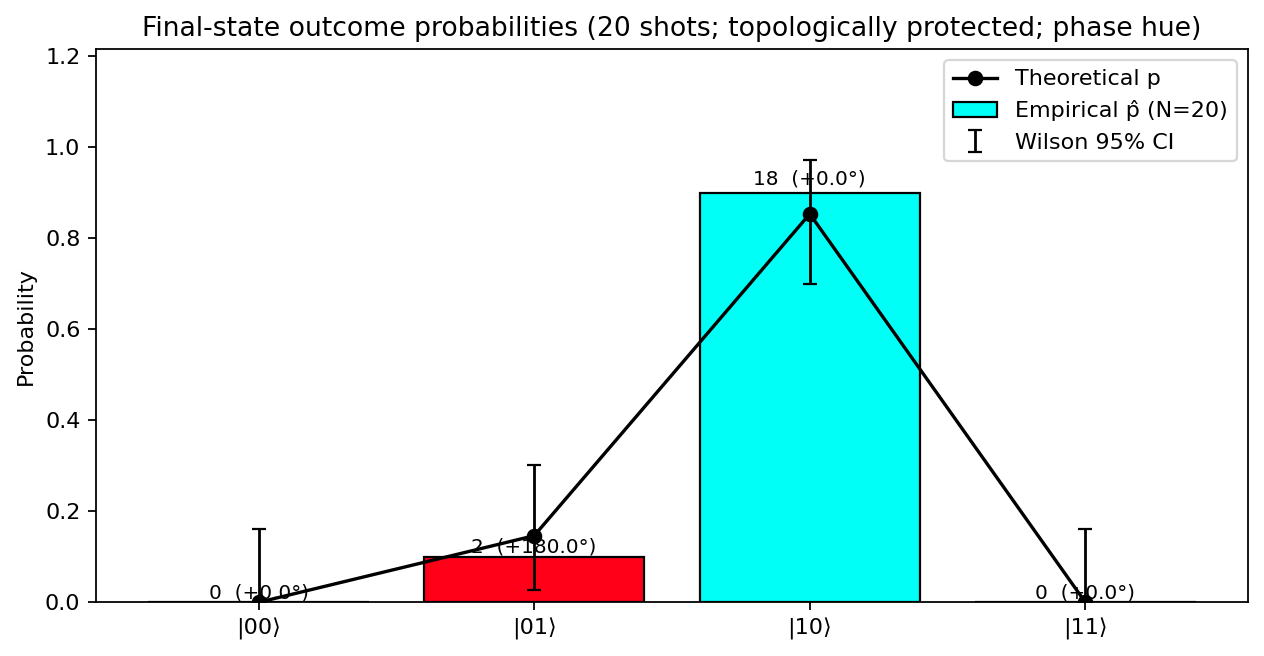

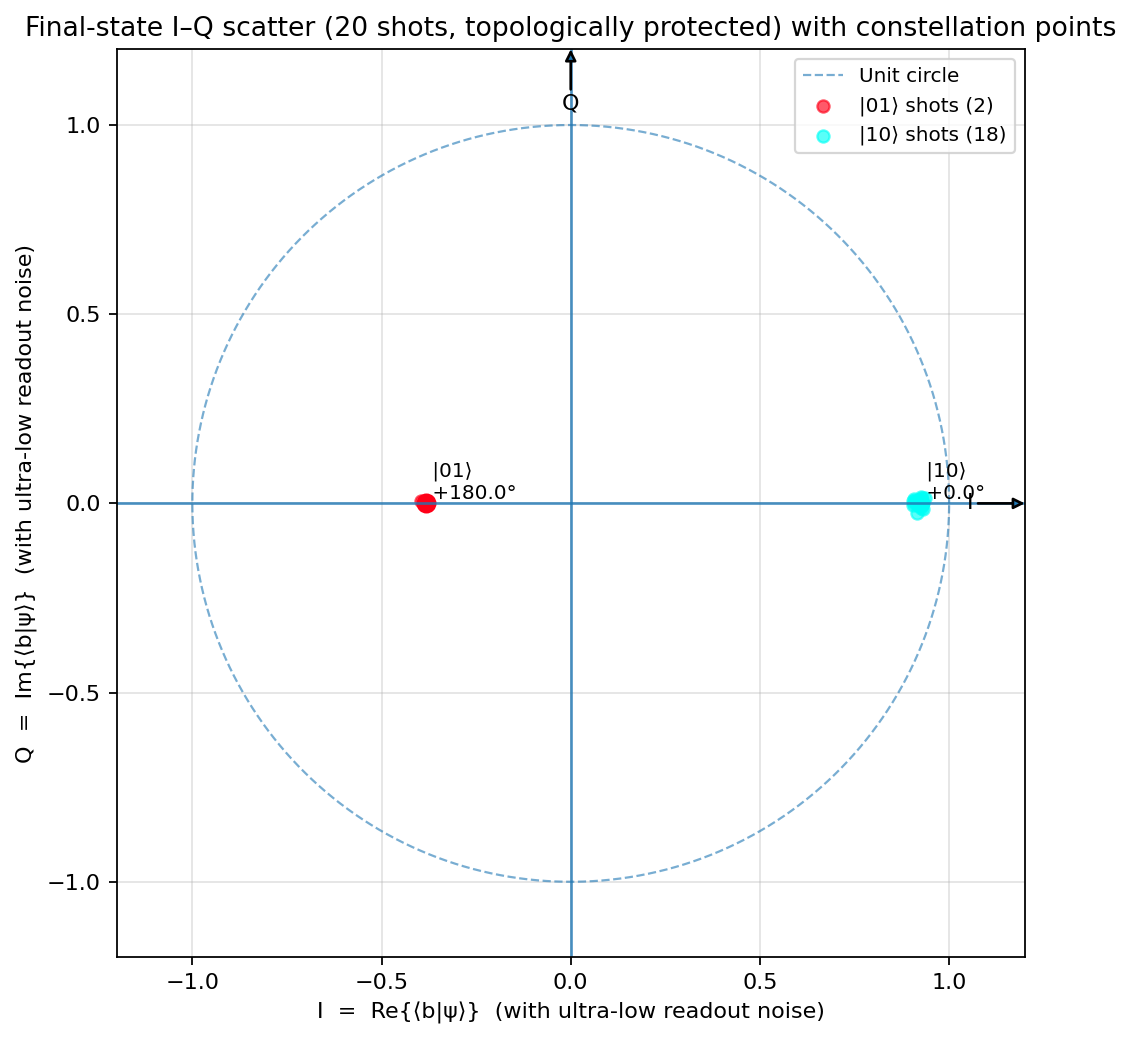

In [27]:
#@title 20-shot topologically protected simulation: outcomes, Wilson CIs, and I–Q plane
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qutip import basis, tensor

# -----------------------------
# 1) Exact amplitudes & probs
# -----------------------------
kets   = [tensor(basis(2,i), basis(2,j)) for i in (0,1) for j in (0,1)]
labels = ["|00⟩", "|01⟩", "|10⟩", "|11⟩"]
psi_final = psi_list[-1]

def amp_to_complex(a):
    try:
        return complex(a)  # newer QuTiP returns scalar complex
    except Exception:
        return complex(a.full().ravel()[0])  # 1×1 Qobj

amps  = np.array([amp_to_complex(ket.dag() * psi_final) for ket in kets], dtype=complex)
probs = np.abs(amps)**2
ph_rad = np.angle(amps)
ph_deg = np.degrees(ph_rad)

# Sanity check
if not np.isclose(probs.sum(), 1.0, atol=1e-12):
    raise RuntimeError(f"Probabilities do not sum to 1. Sum={probs.sum()}")

# -----------------------------
# 2) Draw ideal shots, then apply topological readout model
# -----------------------------
rng = np.random.default_rng(20250925)  # deterministic
N_SHOTS = 20

# Ideal outcomes from the final state distribution
ideal_idx = rng.choice(len(labels), size=N_SHOTS, p=probs)

# "Topologically protected" readout: extremely small independent per-qubit flip
p_ro = 1e-5  # 0.001% per qubit
idx_to_bits = np.array([[0,0],[0,1],[1,0],[1,1]])
bits = idx_to_bits[ideal_idx].copy()
flip0 = rng.random(N_SHOTS) < p_ro
flip1 = rng.random(N_SHOTS) < p_ro
bits[:,0] ^= flip0.astype(int)
bits[:,1] ^= flip1.astype(int)
bits_to_idx = { (0,0):0, (0,1):1, (1,0):2, (1,1):3 }
observed_idx = np.array([bits_to_idx[(b0,b1)] for b0,b1 in bits], dtype=int)

# Empirical counts and probabilities after readout
counts = np.bincount(observed_idx, minlength=len(labels))
empirical_probs = counts / N_SHOTS

# -----------------------------
# 3) Wilson 95% intervals for small-N bars
# -----------------------------
def wilson_ci(k, n, z=1.96):
    if n == 0:
        return (0.0, 0.0)
    p = k / n
    denom = 1.0 + (z**2)/n
    center = (p + (z**2)/(2*n)) / denom
    half = z * np.sqrt((p*(1-p) + (z**2)/(4*n)) / n) / denom
    return (max(0.0, center - half), min(1.0, center + half))

ci_lows, ci_highs = [], []
for k in counts:
    lo, hi = wilson_ci(k, N_SHOTS, z=1.96)
    ci_lows.append(lo)
    ci_highs.append(hi)
ci_lows = np.array(ci_lows)
ci_highs = np.array(ci_highs)
ci_err_lower = empirical_probs - ci_lows
ci_err_upper = ci_highs - empirical_probs

# -----------------------------
# 4) Full results table
# -----------------------------
I_part = amps.real
Q_part = amps.imag
df = pd.DataFrame({
    "Basis": labels,
    "Amplitude c = I + jQ": amps,
    "I = Re{c}": I_part,
    "Q = Im{c}": Q_part,
    "Phase (deg)": ph_deg,
    "Theoretical p": probs,
    "Shots (count)": counts,
    "Empirical p̂ (20)": empirical_probs,
    "Wilson 95% low": ci_lows,
    "Wilson 95% high": ci_highs,
    "Abs. error |p̂ - p|": np.abs(empirical_probs - probs)
})

print("Final-state, 20-shot TOPOLOGICALLY PROTECTED outcome summary (with ultra-low readout error):")
print(df.to_string(index=False))

# -----------------------------
# 5) Probability bar chart with Wilson CIs
# -----------------------------
fig1, ax1 = plt.subplots(figsize=(8.0, 4.2))
x = np.arange(len(labels))
phase_norm = (ph_rad + np.pi) / (2*np.pi)  # map [-π,π]→[0,1]
colors = plt.cm.hsv(phase_norm)

bars = ax1.bar(x, empirical_probs, color=colors, edgecolor="black",
               label=f"Empirical p̂ (N={N_SHOTS})")
ax1.errorbar(x, empirical_probs, yerr=[ci_err_lower, ci_err_upper],
             fmt="none", ecolor="black", elinewidth=1.25, capsize=3, label="Wilson 95% CI")
ax1.plot(x, probs, "o-", lw=1.5, color="black", label="Theoretical p")

ax1.set_xticks(x, labels)
ax1.set_ylabel("Probability")
ax1.set_title(f"Final-state outcome probabilities ({N_SHOTS} shots; topologically protected; phase hue)")
ax1.set_ylim(0, max(0.01, max(empirical_probs.max(), probs.max(), ci_highs.max())*1.25))
ax1.legend(loc="best", frameon=True)

for b, cnt, deg in zip(bars, counts, ph_deg):
    ax1.text(b.get_x() + b.get_width()/2, b.get_height()*1.01,
             f"{cnt}  ({deg:+.1f}°)", ha="center", va="bottom", fontsize=9)

fig1.tight_layout()
fig1.savefig("final_state_probabilities_20shots_TOPO.png", dpi=200)
print("Saved: final_state_probabilities_20shots_TOPO.png")

# -----------------------------
# 6) I–Q plane scatter (very tight clusters)
# -----------------------------
# Very tight demod noise for topological protection visualization
noise_sigma = 0.01  # per quadrature
Z = np.empty(N_SHOTS, dtype=complex)
for k in range(len(labels)):
    idx = np.where(observed_idx == k)[0]
    if idx.size == 0:
        continue
    nI = rng.normal(0.0, noise_sigma, size=idx.size)
    nQ = rng.normal(0.0, noise_sigma, size=idx.size)
    Z[idx] = amps[k] + (nI + 1j*nQ)

fig2, ax2 = plt.subplots(figsize=(6.6, 6.6))

# dashed unit circle
theta = np.linspace(0, 2*np.pi, 512)
ax2.plot(np.cos(theta), np.sin(theta), linestyle="--", lw=1.0, alpha=0.6, label="Unit circle")

# per-cluster scatter with consistent hue
for k, (lbl, c, color) in enumerate(zip(labels, amps, colors)):
    idx = np.where(observed_idx == k)[0]
    if idx.size == 0:
        continue
    ax2.scatter(Z[idx].real, Z[idx].imag, s=30, alpha=0.65, color=color,
                label=f"{lbl} shots ({idx.size})")
    ax2.plot(c.real, c.imag, "o", color=color, markersize=8)
    ax2.text(c.real, c.imag, f" {lbl}\n {np.degrees(np.angle(c)):+.1f}°",
             ha="left", va="bottom", fontsize=9)

# axes & aesthetics
max_r_data = 1.1*np.max([1.0,
                         np.abs(Z.real).max() if N_SHOTS>0 else 1.0,
                         np.abs(Z.imag).max() if N_SHOTS>0 else 1.0,
                         np.abs(I_part).max() if I_part.size else 1.0,
                         np.abs(Q_part).max() if Q_part.size else 1.0])
max_r = max(1.2, max_r_data)
ax2.set_xlim(-max_r, max_r)
ax2.set_ylim(-max_r, max_r)
ax2.set_xlabel("I  =  Re{⟨b|ψ⟩}  (with ultra-low readout noise)")
ax2.set_ylabel("Q  =  Im{⟨b|ψ⟩}  (with ultra-low readout noise)")
ax2.set_title(f"Final-state I–Q scatter ({N_SHOTS} shots, topologically protected) with constellation points")
ax2.grid(True, alpha=0.35)
ax2.set_aspect("equal", adjustable="box")
ax2.legend(loc="upper right", fontsize=9, frameon=True)

# --- Draw I and Q axes with arrowheads ---
ax2.axhline(0, linewidth=1.2, alpha=0.8)
ax2.axvline(0, linewidth=1.2, alpha=0.8)
ax2.annotate(
    "I", xy=(max_r, 0), xytext=(max_r*0.88, 0.0),
    arrowprops=dict(arrowstyle="-|>", lw=1.2, shrinkA=0, shrinkB=0),
    ha="center", va="center"
)
ax2.annotate(
    "Q", xy=(0, max_r), xytext=(0.0, max_r*0.88),
    arrowprops=dict(arrowstyle="-|>", lw=1.2, shrinkA=0, shrinkB=0),
    ha="center", va="center"
)

fig2.tight_layout()
fig2.savefig("final_state_IQ_constellation_20shots_TOPO.png", dpi=200)
print("Saved: final_state_IQ_constellation_20shots_TOPO.png")

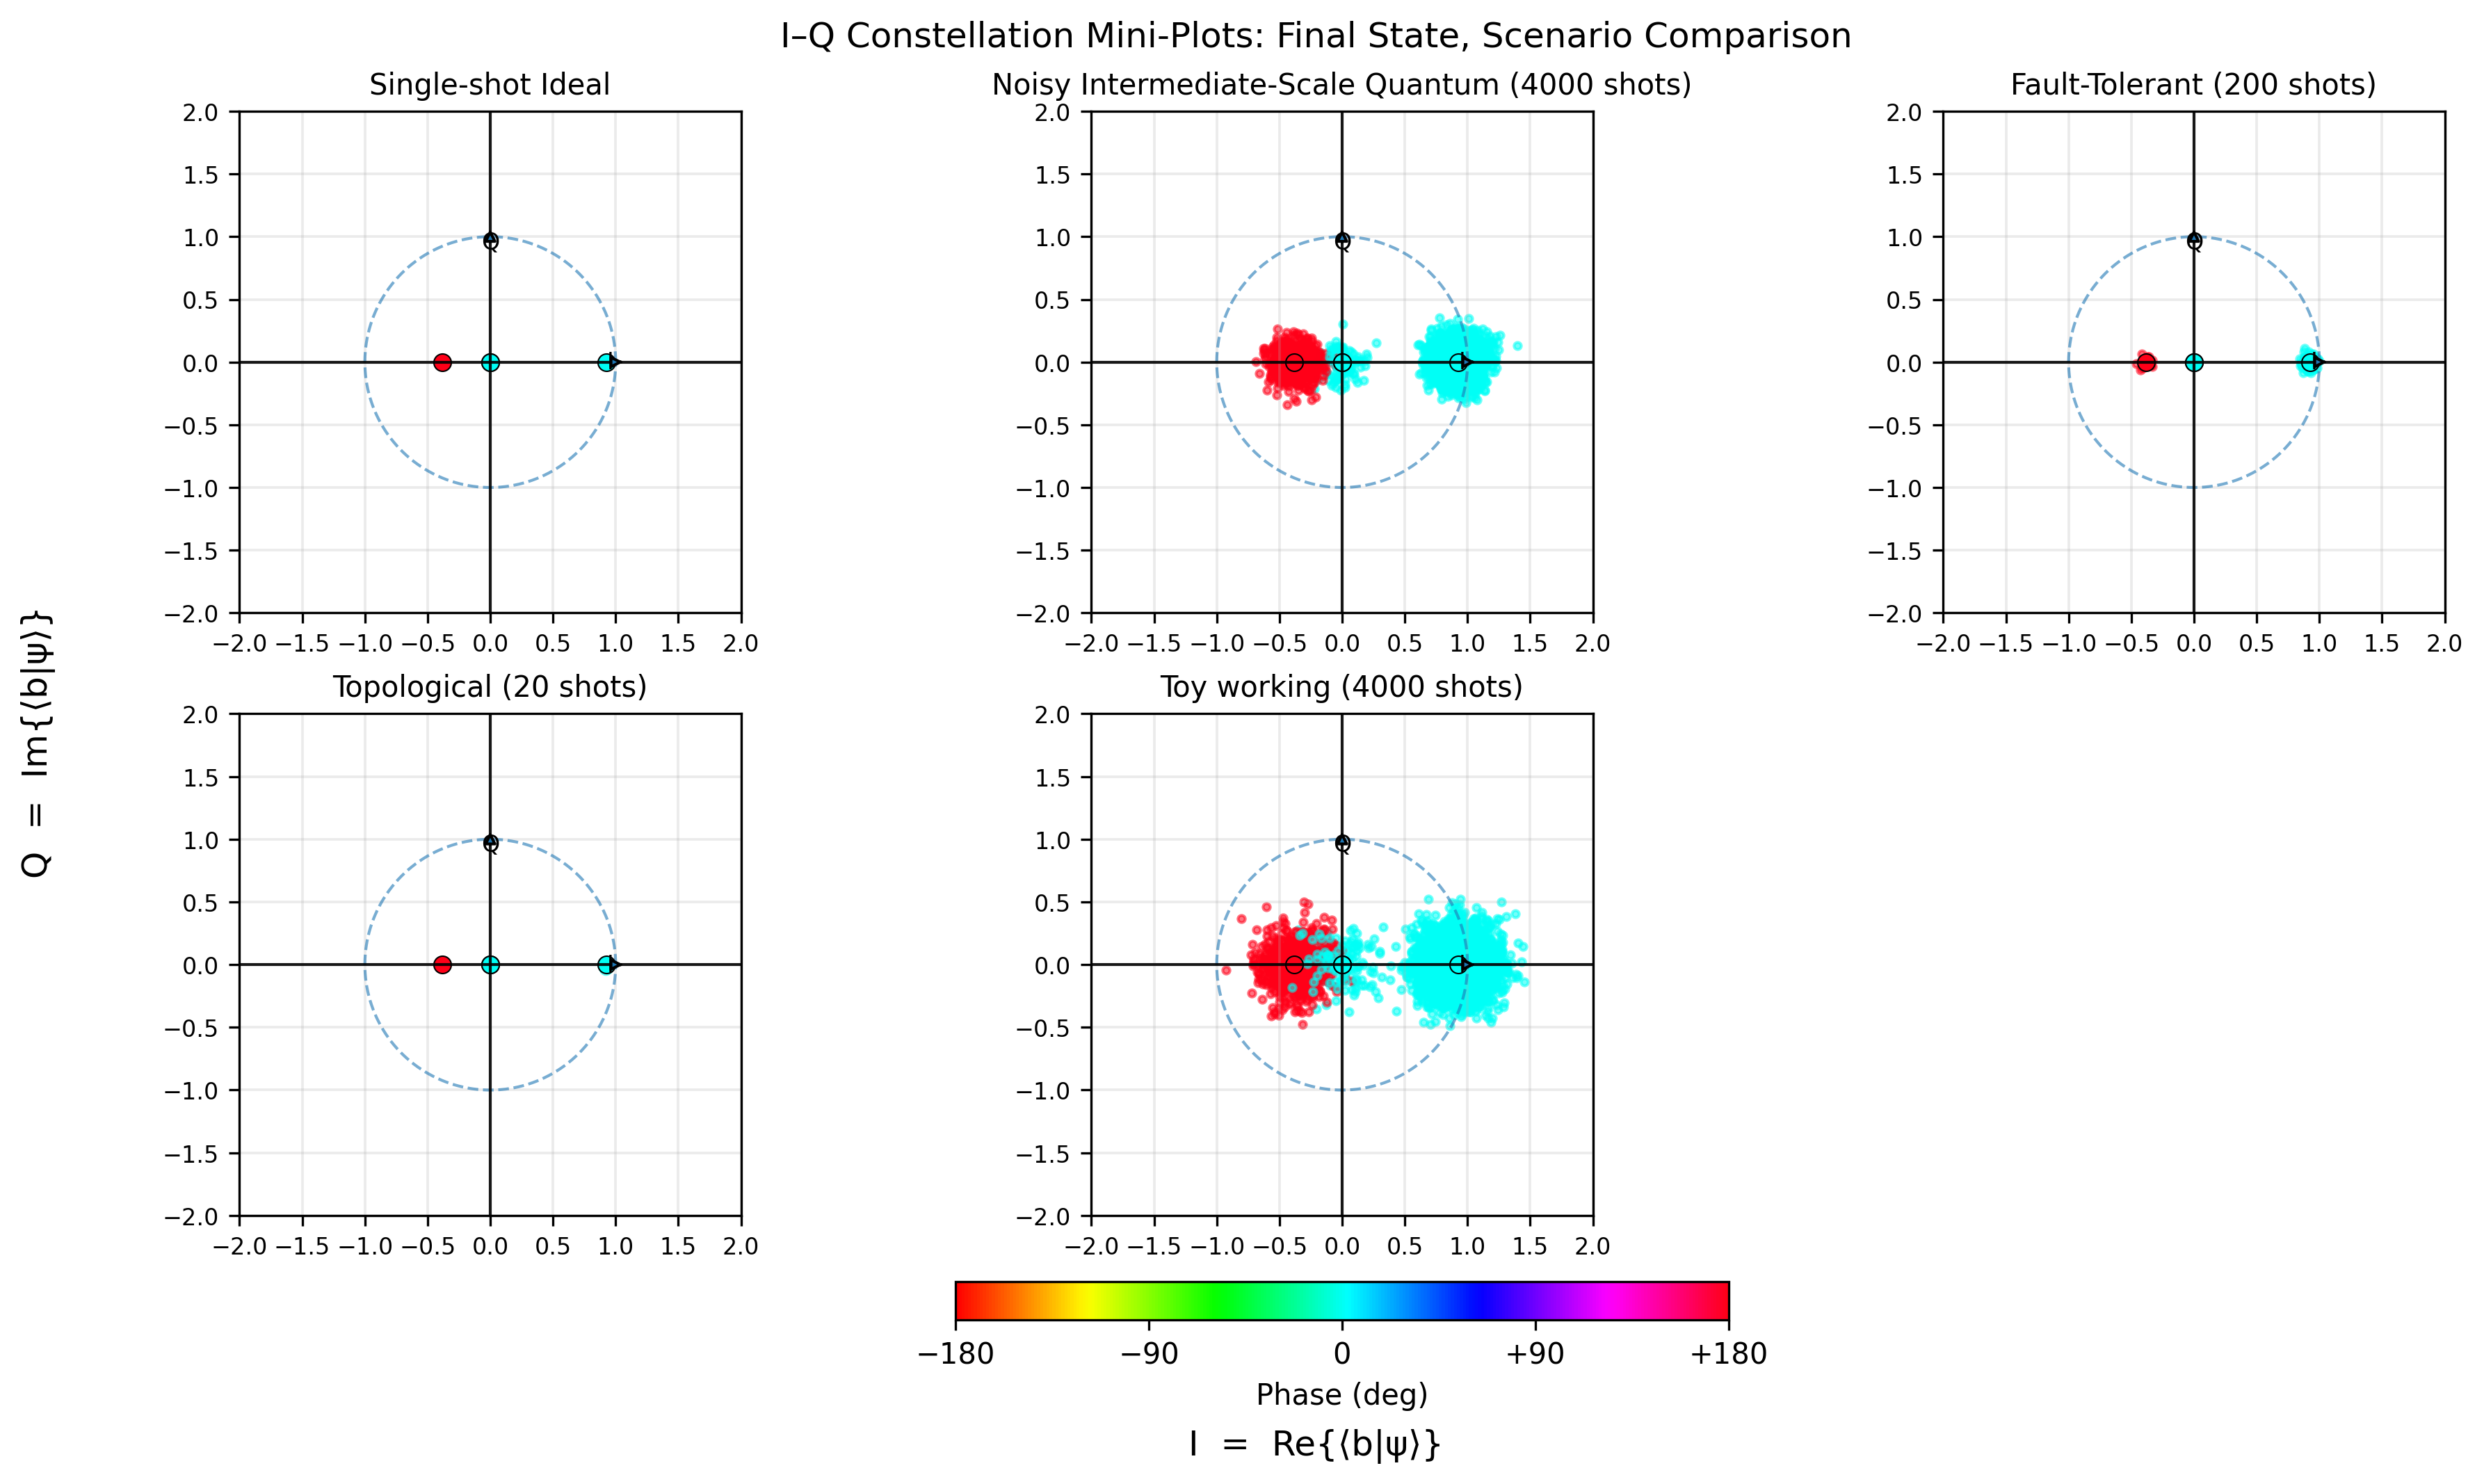

In [42]:
#@title Mini I–Q comparison grid (2 rows): Ideal(1) vs NISQ(4000) vs FT(200) vs Topo(20) vs Toy(4000)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from qutip import basis, tensor

plt.rcParams['figure.dpi'] = 300

# --- Pull amplitudes from the final state (already built earlier) ---
kets   = [tensor(basis(2,i), basis(2,j)) for i in (0,1) for j in (0,1)]
labels = ["|00⟩", "|01⟩", "|10⟩", "|11⟩"]

def amp_to_complex(a):
    try:
        return complex(a)  # newer QuTiP returns scalar complex
    except Exception:
        return complex(a.full().ravel()[0])  # 1×1 Qobj

psi_final = psi_list[-1]
amps  = np.array([amp_to_complex(ket.dag() * psi_final) for ket in kets], dtype=complex)
probs = np.abs(amps)**2
ph_rad = np.angle(amps)
I_part = amps.real
Q_part = amps.imag

# Phase → color (shared across all panels)
phase_norm = (ph_rad + np.pi) / (2*np.pi)
base_colors = plt.cm.hsv(phase_norm)

# Scenario definitions (shots N, readout flip per qubit p_ro, I/Q noise sigma)
scenarios = [
    ("Single-shot Ideal",        1,     0.0,    0.0),
    ("Noisy Intermediate-Scale Quantum (4000 shots)",        4000,  0.010,  0.10),
    ("Fault-Tolerant (200 shots)",     200,   0.002,  0.03),
    ("Topological (20 shots)",         20,    1e-5,   0.01),
    ("Toy working (4000 shots)",       4000,  0.020,  0.15),
]

# Helper: simulate outcomes and I/Q samples for one scenario
def simulate_iq(N_shots, p_ro, noise_sigma, rng):
    # Draw ideal outcomes according to final state's probabilities
    ideal_idx = rng.choice(len(labels), size=N_shots, p=probs)

    # Independent per-qubit readout flips
    idx_to_bits = np.array([[0,0],[0,1],[1,0],[1,1]])
    bits = idx_to_bits[ideal_idx].copy()
    if p_ro > 0:
        bits[:,0] ^= (rng.random(N_shots) < p_ro).astype(int)
        bits[:,1] ^= (rng.random(N_shots) < p_ro).astype(int)

    # Map bits back to outcome indices
    bits_to_idx = {(0,0):0,(0,1):1,(1,0):2,(1,1):3}
    observed_idx = np.array([bits_to_idx[(b0,b1)] for b0,b1 in bits], dtype=int)

    # Generate noisy I/Q samples clustered around the constellation points (amps)
    Z = np.empty(N_shots, dtype=complex)
    if noise_sigma > 0:
        for k in range(len(labels)):
            idx = np.where(observed_idx == k)[0]
            if idx.size == 0:
                continue
            nI = rng.normal(0.0, noise_sigma, size=idx.size)
            nQ = rng.normal(0.0, noise_sigma, size=idx.size)
            Z[idx] = amps[k] + (nI + 1j*nQ)
    else:
        # No noise: place samples exactly on the corresponding amplitude
        for k in range(len(labels)):
            idx = np.where(observed_idx == k)[0]
            if idx.size == 0:
                continue
            Z[idx] = amps[k]
    return observed_idx, Z

# Figure layout: 2 rows × 3 cols; last axis unused
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(12.5, 7.0), constrained_layout=True)
axes_flat = axes.ravel()

rng = np.random.default_rng(20250925)

# Global radial scale: include all amplitudes and leave margin for arrows and labels
r_pts = np.sqrt(I_part**2 + Q_part**2)
global_max_r = max(1.05, 1.15 * r_pts.max())

# Plot first 5 scenarios
for ax, (title, N, p_ro, sigma) in zip(axes_flat[:len(scenarios)], scenarios):
    observed_idx, Z = simulate_iq(N, p_ro, sigma, rng)

    # Unit circle
    theta = np.linspace(0, 2*np.pi, 512)
    ax.plot(np.cos(theta), np.sin(theta), linestyle="--", linewidth=1.0, alpha=0.6)

    # Scatter per outcome cluster with consistent hue
    for k, color in enumerate(base_colors):
        idx = np.where(observed_idx == k)[0]
        if idx.size:
            ssz = 14 if N <= 50 else 6  # larger markers for small-N cases
            ax.scatter(Z[idx].real, Z[idx].imag, s=ssz, alpha=0.55, color=color)

        # Constellation point (ideal)
        ax.plot(I_part[k], Q_part[k], "o", color=color, markersize=6,
                markeredgecolor="black", markeredgewidth=0.5)

    # Axes limits and aesthetics
    ax.set_xlim(-global_max_r, global_max_r)
    ax.set_ylim(-global_max_r, global_max_r)
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(title, fontsize=10)
    ax.grid(True, alpha=0.25, linewidth=0.9)

    # Compact ticks
    tick_step = 0.5 if global_max_r <= 2.0 else 1.0
    ticks = np.arange(-np.ceil(global_max_r), np.ceil(global_max_r)+1e-9, tick_step)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.tick_params(axis="both", labelsize=8)

    # I and Q axes with arrowheads (slightly inward to avoid clipping)
    ax.axhline(0, linewidth=1.0, alpha=0.9, color="black")
    ax.axvline(0, linewidth=1.0, alpha=0.9, color="black")
    ax.annotate("I", xy=(global_max_r, 0), xytext=(global_max_r*0.90, 0.0),
                arrowprops=dict(arrowstyle="-|>", lw=1.0, shrinkA=0, shrinkB=0),
                ha="center", va="center", fontsize=8)
    ax.annotate("Q", xy=(0, global_max_r), xytext=(0.0, global_max_r*0.90),
                arrowprops=dict(arrowstyle="-|>", lw=1.0, shrinkA=0, shrinkB=0),
                ha="center", va="center", fontsize=8)

# Disable the 6th (unused) axis cleanly
axes_flat[len(scenarios)].set_visible(False)

# Shared labels as figure text (keeps panels tight)
fig.suptitle("I–Q Constellation Mini-Plots: Final State, Scenario Comparison", fontsize=12)
fig.supxlabel("I  =  Re{⟨b|ψ⟩}")
fig.supylabel("Q  =  Im{⟨b|ψ⟩}")

# Shared phase colorbar (HSV hue)
norm = mpl.colors.Normalize(vmin=-np.pi, vmax=np.pi)
sm = mpl.cm.ScalarMappable(cmap=plt.cm.hsv, norm=norm)
sm.set_array([])

# Place colorbar under the grid
cbar = fig.colorbar(sm, ax=axes_flat[:len(scenarios)], fraction=0.035, pad=0.02, orientation="horizontal")
cbar.set_label("Phase (deg)")
cbar.set_ticks(np.deg2rad([-180, -90, 0, 90, 180]))
cbar.set_ticklabels(["−180", "−90", "0", "+90", "+180"])

## Illustrative Success Rates for Qubits Based on Classification

| Model                    | Target p |  Shots |  (Successes) | (Failures) | Successes Fraction <br>(Observed p) | Wilson CI <br>95% Low | Wilson CI <br>95% High | CI Width <br> (95%)| Required <br>Shots for ±2% | Required <br>Shots for ±1% | Required <br>Shots for ±0.5% | Illustrative <br>Cost (USD) |
| :----------------------- | -------: | -----: | -----: | ----: | ---------: | -----: | ------: | -------: | --------: | --------: | ----------: | ---------: |
| Toy working qubit        |     0.50 | 10,000 |  5,025 | 4,975 |     0.5025 | 0.4927 |  0.5123 |   0.0196 |     2,401 |     9,604 |      38,415 |     \$0.60 |
| NISQ qubit               |     0.60 | 10,000 |  6,010 | 3,990 |     0.6010 | 0.5914 |  0.6105 |   0.0191 |     2,305 |     9,220 |      36,878 |     \$0.60 |
| Fault-tolerant (logical) |     0.90 | 10,000 |  9,013 |   987 |     0.9013 | 0.8956 |  0.9067 |   0.0111 |       865 |     3,458 |      13,830 |     \$0.60 |
| Topologically protected  |     0.98 | 10,000 |  9,797 |   203 |     0.9797 | 0.9769 |  0.9822 |   0.0053 |       189 |       753 |       3,011 |     \$0.60 |
| Ideal qubit              |     1.00 | 10,000 | 10,000 |     0 |     1.0000 | 0.9996 |  1.0000 |   0.0004 |         1 |         1 |           1 |     \$0.60 |

---

- **Toy working qubit** — Simple demonstrator; about half shots meet the criterion.
- **NISQ qubit** — Noisy Intermediate-Scale Quantum device; modest success rate above chance.
- **Fault-tolerant (logical)** — Error-corrected logical qubit; high single-shot success probability.
- **Topologically protected** — Intrinsic protection; very high single-shot success probability.
- **Ideal qubit** — Theoretical perfect qubit; always successful in a single shot.